## CorrGAN

Generating realistic financial correlation matrices is highly complex.
Correlation matrices are useful for risk management, asset allocation, hedging instrument selection, pricing models, etc.

Hüttner, Mai and Mineo (2018) concluded that "To the best of our knowledge, there is no algorithm available for the generation of
reasonably random [financial] correlation matrices with the
Perron-Frobenius property. [...] we expect the task  of finding such correlation matrices to be highly complex"

This problem was addressed by Dr. Marti (2020a) by using a generative adversarial network (a GAN, named CorrGAN) that
can generate realistic financial correlation matrices. CorrGAN was trained on empirical correlation matrices
based on the S&P 500 returns. CorrGAN generates correlation matrices that have many "stylized facts" seen in
empirical correlation matrices.

In [1]:
# Import packages
import os
import warnings
import random

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import yfinance as yf

# Import MlFinLab tools
from mlfinlab.data_generation.corrgan import sample_from_corrgan
from mlfinlab.data_generation.data_verification import (plot_pairwise_dist, plot_eigenvalues,
                                                        plot_eigenvectors, plot_hierarchical_structure,
                                                        plot_mst_degree_count, plot_stylized_facts)

warnings.filterwarnings('ignore')

# Setting seeds
random.seed(2814)
np.random.seed(2814)
tf.random.set_seed(2814)

In [2]:
# Tickes to to use
SP_ASSETS = ["AAPL", "MSFT", "AMZN", "FB", "GOOG", "GOOGL", "JNJ", "PG", "V", "JPM", 
             "UNH", "HD", "MA", "NVDA", "VZ", "DIS", "PYPL", "ADBE", "T", "NFLX",
             "PFE", "MRK", "INTC", "BAC", "CMCSA", "PEP", "WMT", "KO", "XOM", "CSCO"]

## Correlation Matrices

Financial correlation matrices are constructed by using the correlation of stock returns over a time frame. Pearson's correlation coefficient is most commonly used. It is defined as

$p_{X, Y} = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$

Where $p$ is the correlation coefficient, $cov$ is the covariance. $\sigma_X$ is the standard deviation of $X$. $\sigma_Y$ is the standard deviation of $Y$

Note that the Pearson's correlation only captures linear effects. If two variables have a strong non-linear dependency (squared or abs for example)
the Pearson correlation won't find any pattern between them. There are other methods to measure codependence not covered here. For more information, check our documentation and implementations of Codependence.

Correlation matrices are useful for risk management, asset allocation, hedging instrument selection, pricing models, etc.
 For example, in mean-variance optimization of portfolios, risk and return are measured by the variance and mean of the portfolio returns. One way to calculate the
 variance of a portfolio is by using the covariance matrix of those returns.
 Usually, this covariance matrix is estimated from historical data, which makes it subject to estimation errors and bias.
The relationship between correlation and covariance is shown above.

As explained by Laloux et al. (2000), analyzing covariance and correlation matrices is useful to assess the risk of a portfolio
during high-stress periods. They explain, "the probability of large losses for a certain portfolio or option book is dominated by correlated moves of its different constituents – for example,a position which is simultaneously long in stocks and short in bonds will be risky because stocks and bonds usually move in opposite directions in crisis periods."

Empirical financial correlation matrices exhibit certain "stylized facts" that researchers have found (Marti, 2020a):

1. Distribution of pairwise correlations is significantly shifted to the positive.
2. Eigenvalues follow the Marchenko-Pastur distribution, but for a very large first eigenvalue (the market).
3. Eigenvalues follow the Marchenko-Pastur distribution, but for a couple of other large eigenvalues (industries).
4. Perron-Frobenius property (first eigenvector has positive entries).
5. Hierarchical structure of correlations.
6. Scale-free property of the corresponding Minimum Spanning Tree (MST).

In the next sections we show how to generate correlation matrices from real stock returns and from CorrGAN. Then we compare their stylized facts.

[*********************100%***********************]  30 of 30 completed


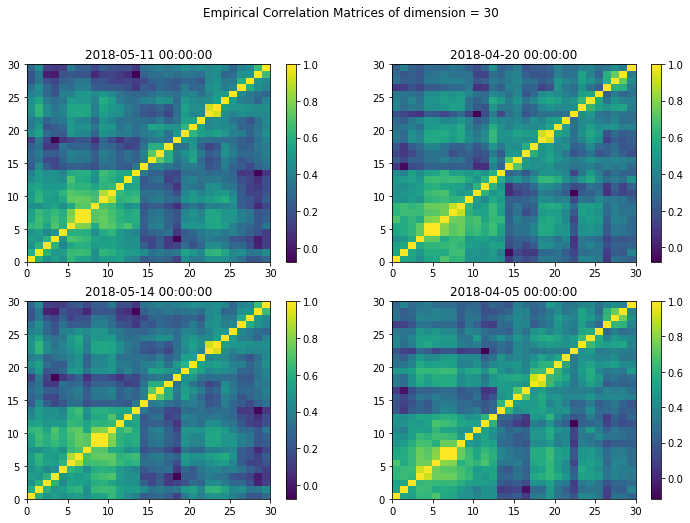

In [3]:
# Adapted from: https://marti.ai/ml/2019/10/13/tf-dcgan-financial-correlation-matrices.html

dimensions = 30

# Download stock returns and compute correlations
prices = yf.download(tickers=" ".join(SP_ASSETS), start="2017-08-01", end="2018-08-01")['Close']
prices = prices.pct_change()
rolling_corr = prices.rolling(252, min_periods=252//2).corr().dropna()
tri_rows, tri_cols = np.triu_indices(dimensions, k=1)

# Plot a few correlation matrices
plt.figure(figsize=(12, 8))
plt.suptitle("Empirical Correlation Matrices of dimension = {}".format(dimensions)) 
i = 0
for date in random.sample(rolling_corr.groupby(level=0).indices.keys(), 4):
    corr_mat = rolling_corr.loc[date].values
    
    # Arrange with hierarchical clustering by maximizing the sum of the
    # similarities between adjacent leaves
    dist = 1 - corr_mat
    linkage_mat = hierarchy.linkage(dist[tri_rows, tri_cols], method="ward")
    optimal_leaves = hierarchy.optimal_leaf_ordering(linkage_mat, dist[tri_rows, tri_cols])
    optimal_ordering = hierarchy.leaves_list(optimal_leaves)
    ordered_corr = corr_mat[optimal_ordering, :][:, optimal_ordering]
    
    # Plot it
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(ordered_corr, cmap='viridis')
    plt.colorbar()
    plt.title(date)
    i += 1
plt.show()

CorrGAN is a novel approach for sampling realistic financial correlation matrices. It uses a GAN that is able to recover all of the stylized
facts exhibited by empirical correlation matrices.
It was trained on approximately 10,000 empirical correlation matrices estimated on S&P 500 returns sorted using $\pi_H$, where $\pi_H$ is a permutation induced by a hierarchical clustering algorithm.
The generated matrix is post processed using an alternating projections method to find the nearest correlation matrix with respect to the Frobenius norm.
Using these methods, CorrGAN is able to generate correlation matrices that satisfy the stylized facts found in empirical correlation matrices.


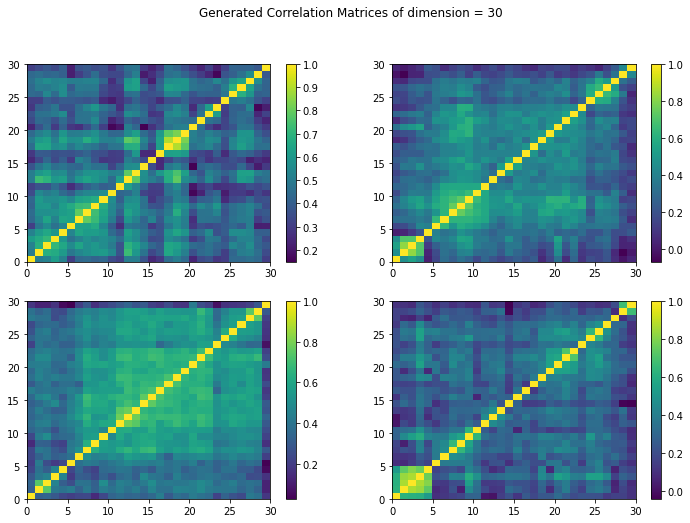

In [4]:
# Sample from CorrGAN.
corrgan_mats = sample_from_corrgan(model_loc="{}/corrgan_models".format(os.getcwd()),
                                    dim=dimensions, 
                                    n_samples=len(rolling_corr.index.get_level_values(0).unique()))

# Plot a few samples
plt.figure(figsize=(12, 8))
plt.suptitle("Generated Correlation Matrices of dimension = {}".format(dimensions)) 

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.pcolormesh(corrgan_mats[i], cmap='viridis')
    plt.colorbar()
plt.show()

## Stylized Facts Comparison 

But how do both matrices compare to their stylized facts? Below we analyze them.
We use the provided function in mlfinlab `plot_stylized_facts` to visualize all facts.

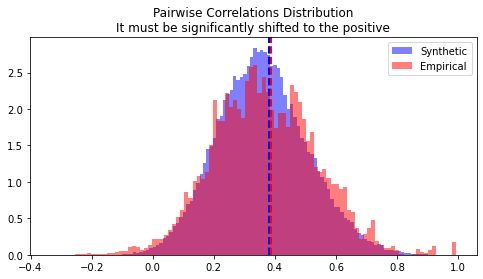

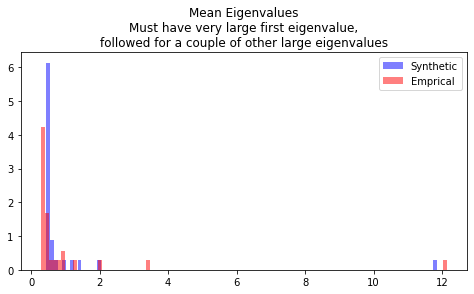

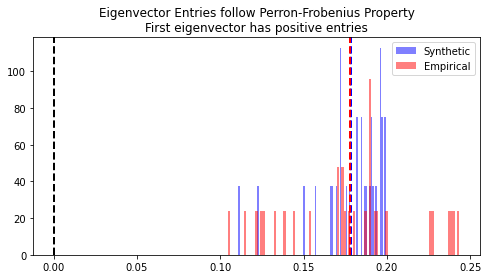

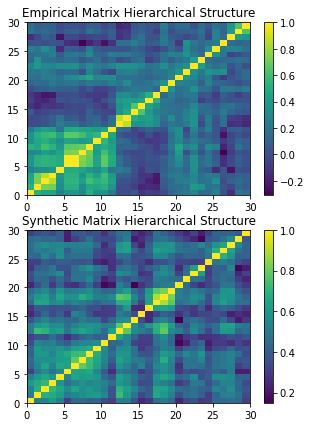

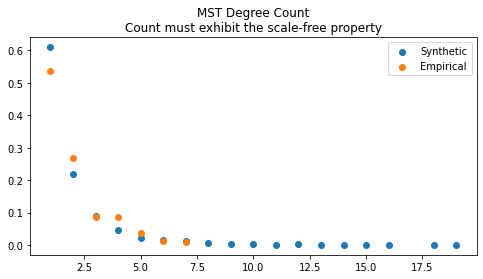

In [5]:
# Convert pandas dataframe to numpy array
empirical_mats = []
for date, corr_mat in rolling_corr.groupby(level=0):
    empirical_mats.append(corr_mat.values)
empirical_mats = np.array(empirical_mats)

plot_stylized_facts(empirical_mats, corrgan_mats)

### 1. Distribution of pairwise correlations is significantly shifted to the positive

In this figure, the positive shift to the right of the correlation factors is observed. Even though there are a few discrepancies in the tails of the empirical and generated distributions, this stylized factor holds true for both.

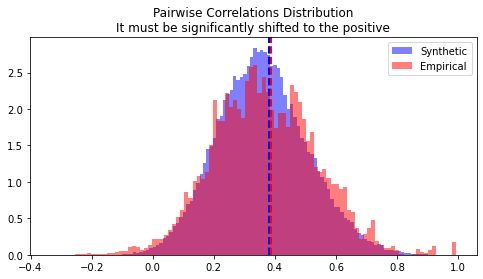

In [6]:
plot_pairwise_dist(empirical_mats, corrgan_mats);

### 2. Eigenvalues follow the Marchenko-Pastur distribution, but for a very large first eigenvalue (the market)  and 3. A couple of other large eigenvalues (industries).

In this figure, the distribution of eigenvalues closely matches the empirical and generated values.
We observe a large first eigenvalue, followed for a few eigenvalues, larger than the remaining ones.

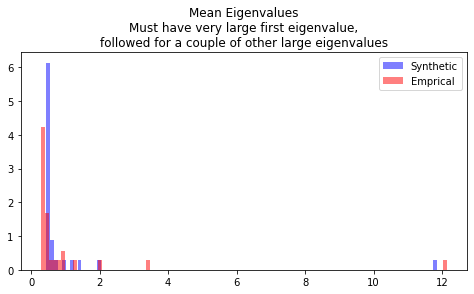

In [7]:
plot_eigenvalues(empirical_mats, corrgan_mats);

### 4. Perron-Frobenius property (first eigenvector has positive entries).

In this figure, the distribution of the first eigenvector entries are all positive. We can observe both empirical and generated eigenvector distributions are similar, and the Perron-Frobenius property holds true for both.

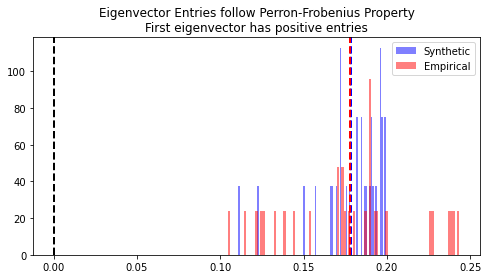

In [8]:
plot_eigenvectors(empirical_mats, corrgan_mats);

### 5. Hierarchical structure of correlations.

In this figure, we observe heirarchical clustering for both the empirical and generated matrices. Note how dimensions 0-12 in the empirical matrix, and dimensions 0-14 in the generated matrix exhibit similar, although of different magnitude, clusters.

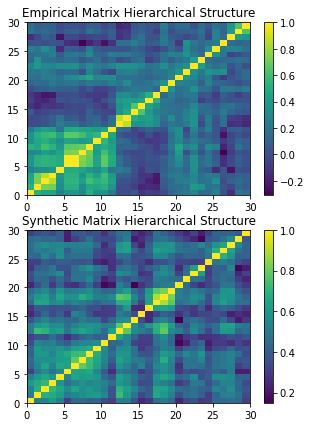

In [9]:
plot_hierarchical_structure(empirical_mats, corrgan_mats);

### 6. Scale-free property of the corresponding Minimum Spanning Tree (MST)

In this last figure, we can observe that the MST distribution of node degrees conforms to the scale-free property (degree distribution follows a power law) for both empirical and generated data.

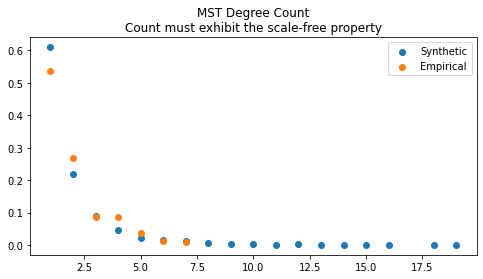

In [10]:
plot_mst_degree_count(empirical_mats, corrgan_mats);

### CorrGAN Performance

It should be noted that the higher the dimension CorrGAN generates (up to 200), the longer it takes to compute. For a machine with the following specifications,
we list a table with average run times for several dimensions.

<b>Specifications</b>: <br>
<b>OS</b>: Windows 10 10.0.18362 N/A Build 18362 <br>
<b>Processor</b>: Intel64 Family 6 Model 158 Stepping 12 GenuineIntel ~3600 Mhz <br>
<b>GPU</b>: None <br>
<b>RAM</b>: 32 GB

| Dimension | Number of<br>Samples | Avg Time to finish <br>(seconds) |
|:---------:|:--------------------:|:-----------------------------:|
|     10    |           1          |              0.45             |
|           |          10          |              0.45             |
|           |          100         |              0.52             |
|           |         1000         |              1.31             |
|     20    |           1          |              0.43             |
|           |          10          |              0.65             |
|           |          100         |              2.55             |
|           |         1000         |              19.9             |
|     30    |           1          |              0.92             |
|           |          10          |              4.25             |
|           |          100         |              46.1             |
|     50    |           1          |              5.24             |
|           |          14          |             33.89             |
|     80    |           1          |             18.42             |
|           |           4          |             72.16             |
|    100    |           1          |             30.31             |
|           |           2          |             60.74             |
|    200    |           1          |             156.42            |

### Conclusion

In this notebook, we showed how to generate a realistic correlation matrix from CorrGAN in the mlfinlab package.
We found that:

1. The generated matrices stylized facts closely match to the empirical's stylized facts.
2. Even though there are a few discrepancies regarding positive shifted parwise correlations and the Perron-Frobenius property, we note that all properties hold true for the data generated by CorrGAN.
    - Dr. Marti notes that tails of the distributions are not perfectly simulated by CorrGAN (Marti 2020b).
3. Correlation matrices can be generated without a great time overhead. More powerful CPUs or GPU usage can lower this time.

Special thanks to [Dr. Gautier Marti](https://marti.ai/) for providing the trained models and his blog posts (Marti 2020b) to understand his work.

[references]: #references
## References
1. [Hüttner, A., Mai, J., and Mineo, S. (2018). Portfolio selection based on graphs: Does it align with Markowitz-optimal portfolios?. _Dependence Modeling_, 6(1), pp.63-87](https://www.degruyter.com/view/journals/demo/6/1/article-p63.xml)
<br>
2. [Marti, G., 2020a, May. CorrGAN: Sampling Realistic Financial Correlation Matrices Using Generative Adversarial Networks. In ICASSP 2020-2020 IEEE _International Conference on Acoustics, Speech and Signal Processing (ICASSP)_ (pp. 8459-8463). IEEE](https://arxiv.org/pdf/1910.09504.pdf)
<br>
3. [Marti, G. (2020b) _TF 2.0 DCGAN for 100x100 financial correlation matrices_ [Online]. Available at: https://marti.ai/ml/2019/10/13/tf-dcgan-financial-correlation-matrices.html. (Accessed: 17 Aug 2020)](https://marti.ai/ml/2019/10/13/tf-dcgan-financial-correlation-matrices.html)
<br>
4. [Laloux, L., Cizeau, P., Potters, M. and Bouchaud, J.P., 2000. Random matrix theory and financial correlations. _International Journal of Theoretical and Applied Finance_, 3(03), pp.391-397](https://www.math.nyu.edu/faculty/avellane/LalouxPCA.pdf)